<img src="./image/Nile2.jpg" width="1000" height="50">

[*source*](https://www.livescience.com/nile-river-older-than-thought.html)

## <span style="color:teal"> West Nile Virus Modelling, Cost Analysis and Executive Summary Notebook</span>

---
---

### Content:

#### 1) Modelling : KNearest Neighbours, Support Vector Machines, Logistic Regression, Random Forests, Extra Trees
#### 2) Modelling Summary and Selection
#### 3) Cost-Benefit Analysis
#### 4) Executive Summary

---
---

### Imports

In [1]:
#Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import os
import re
import time
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

#for kernel dying
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

%matplotlib inline
sns.set()

In [2]:
#Loading the necessary datasets
train = pd.read_csv('./assets/train_clean.csv')
test = pd.read_csv('./assets/test_clean.csv')
spray = pd.read_csv('./assets/spray_clean.csv')
weather = pd.read_csv('./assets/weather_clean.csv')
train_weather = pd.read_csv('./assets/train_weather_clean.csv')
train_weather1 = pd.read_csv('./assets/train_weather_clean.csv')
test_weather = pd.read_csv('./assets/test_weather_clean.csv')
test_weather1 = pd.read_csv('./assets/test_weather_clean.csv')

---
---

### Prepare data to set X and Y variable

In [3]:
train_weather.head()

,block,trap,latitude,longitude,nummosquitos,wnvpresent,year,month,day,station,...,resultspeed,resultdir,avgspeed,species_CULEX ERRATICUS,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_CULEX SALINARIUS,species_CULEX TARSALIS,species_CULEX TERRITANS
0,41,2,41.954690,-87.800991,1,0,2007,5,29,1,...,5.8,18,6.5,0,0,1,0,0,0,0
1,41,2,41.954690,-87.800991,1,0,2007,5,29,2,...,5.8,16,7.4,0,0,1,0,0,0,0
2,41,2,41.954690,-87.800991,1,0,2007,5,29,1,...,5.8,18,6.5,0,0,0,1,0,0,0
3,41,2,41.954690,-87.800991,1,0,2007,5,29,2,...,5.8,16,7.4,0,0,0,1,0,0,0
4,62,7,41.994991,-87.769279,1,0,2007,5,29,1,...,5.8,18,6.5,0,0,0,1,0,0,0


In [4]:
train_weather1.drop(columns = 'wnvpresent', inplace=True)
test_weather.drop(columns='id', inplace=True)

In [5]:
train_weather1.head()

,block,trap,latitude,longitude,nummosquitos,year,month,day,station,tmax,...,resultspeed,resultdir,avgspeed,species_CULEX ERRATICUS,species_CULEX PIPIENS,species_CULEX PIPIENS/RESTUANS,species_CULEX RESTUANS,species_CULEX SALINARIUS,species_CULEX TARSALIS,species_CULEX TERRITANS
0,41,2,41.954690,-87.800991,1,2007,5,29,1,88,...,5.8,18,6.5,0,0,1,0,0,0,0
1,41,2,41.954690,-87.800991,1,2007,5,29,2,88,...,5.8,16,7.4,0,0,1,0,0,0,0
2,41,2,41.954690,-87.800991,1,2007,5,29,1,88,...,5.8,18,6.5,0,0,0,1,0,0,0
3,41,2,41.954690,-87.800991,1,2007,5,29,2,88,...,5.8,16,7.4,0,0,0,1,0,0,0
4,62,7,41.994991,-87.769279,1,2007,5,29,1,88,...,5.8,18,6.5,0,0,0,1,0,0,0


In [6]:
# set X variable and target y variable

X = train_weather1
y = train_weather["wnvpresent"]

---
---

### Split data

In [7]:
# split the data into the training and testing sets

X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42
                                                    )

### Apply Standard Scaler and obtain Baseline Score

In [8]:
# standard scaler applied

ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_val = ss.transform(X_val)
test_kaggle = ss.transform(test_weather)


In [9]:
# baseline score

y.value_counts(normalize = True)

0    0.946077
1    0.053923
Name: wnvpresent, dtype: float64

From the value counts, we know that the baseline model will predict the presence of the West Nile Virus 5% of the time (i.e. y=1, normalized)

---
---

## <span style="color:teal"> 1) Modelling</span>

In building our classifier model, we will be looking at the following models: 
- KNearest Neighbour with GridSearchCV
- Support Vector Machines with GridSearchCV
- Logistic Regression with GridSearchCV
- Random Forests with GridSearchCV
- Extra Trees with GridSearchCV

We have decided to GridSearch through the various models so as to identify the best parameters that best classify the presence of the West Nile Virus

---
---

### KNearest Neighbour with GridSearchCV

In [10]:
# instantiate our model

knn = KNeighborsClassifier() 

In [11]:
#Preliminar modeling with cross val score

pre_score_knn = cross_val_score(estimator = knn,
                            X = X_train, 
                            y = y_train,
                            scoring = 'accuracy',
                            cv = 10,
                            verbose = 0)

print('KNN mean score: %5.4f' %np.mean(pre_score_knn))


KNN mean score: 0.9455


In [12]:
# KNN using GridSearch to find optimum KNN value and fit

k_range = list(range(1,31))
weight_options = ["uniform", "distance"]
param_grid_knn = dict(n_neighbors = k_range, weights = weight_options)
gs_knn = GridSearchCV(knn, param_grid_knn, cv=5)
gs_knn.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']})

In [13]:
# check knn best parameter

print(f'KNN best parameter: {gs_knn.best_params_}')

KNN best parameter: {'n_neighbors': 15, 'weights': 'distance'}


In [14]:
# gridsearch best score

print(f'KNN best score: {gs_knn.best_score_}')

KNN best score: 0.9484854968649413


In [15]:
# predictions 

predictions_knn = gs_knn.predict(X_val)

In [16]:
# training score

print(gs_knn.score(X_train, y_train))

1.0


In [17]:
# testing score

print(gs_knn.score(X_val, y_val))

0.9472649267071863


In [18]:
confusion_matrix(y_val, predictions_knn)

array([[5283,    9],
       [ 286,   16]])

In [19]:
tn_knn, fp_knn, fn_knn, tp_knn = confusion_matrix(y_val, predictions_knn).ravel()

In [20]:
print("True Negatives: %s" % tn_knn)
print("False Positives: %s" % fp_knn)
print("False Negatives: %s" % fn_knn)
print("True Positives: %s" % tp_knn)

True Negatives: 5283
False Positives: 9
False Negatives: 286
True Positives: 16


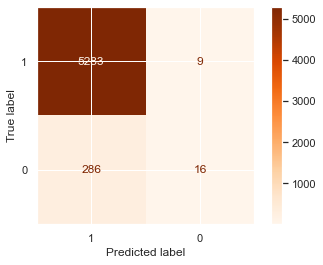

In [21]:
# KNN confusion matrix

plot_confusion_matrix(gs_knn, X_val, y_val, cmap='Oranges', 
                      values_format='d', display_labels=['1', '0']);

In [22]:
# test sensitivity of knn

sens_knn = tp_knn / (tp_knn + fn_knn)
sens_knn

0.052980132450331126

---
---

### Support Vector Machine with GridSearchCV

In [23]:
svc = SVC()

In [24]:
pre_score_svc = cross_val_score(estimator = svc,
                            X = X_train, 
                            y = y_train,
                            scoring = 'accuracy',
                            cv = 10,
                            verbose = 0)

print('Support Vector Machine mean score: %5.4f' %np.mean(pre_score_svc))

Support Vector Machine mean score: 0.9487


In [25]:
# Using GridSearch to find optimum SVC value and fit 


gs_svc = GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1], 'kernel': ['linear']})
gs_svc.fit(X_train,y_train);




In [26]:
# check svc best parameter

print(f'SVC best parameter: {gs_svc.best_params_}')

SVC best parameter: {'C': 0.1, 'kernel': 'linear'}


In [27]:
# gridsearch best score

print(f'SVC best score: {gs_svc.best_score_}')

SVC best score: 0.9471644929019295


In [28]:
# predictions 

predictions_svc = gs_svc.predict(X_val)

In [29]:
# training score

print(gs_svc.score(X_train, y_train))

0.947076435364565


In [30]:
# testing score

print(gs_svc.score(X_val, y_val))

0.9458348230246693


In [31]:
confusion_matrix(y_val, predictions_svc)

array([[5290,    2],
       [ 301,    1]])

In [32]:
tn_svc, fp_svc, fn_svc, tp_svc = confusion_matrix(y_val, predictions_svc).ravel()

In [33]:
print("True Negatives: %s" % tn_svc)
print("False Positives: %s" % fp_svc)
print("False Negatives: %s" % fn_svc)
print("True Positives: %s" % tp_svc)

True Negatives: 5290
False Positives: 2
False Negatives: 301
True Positives: 1


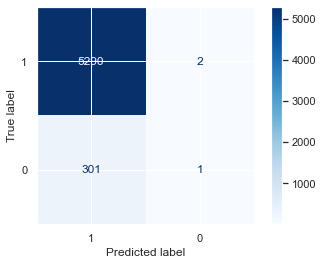

In [34]:
# SVC confusion matrix

plot_confusion_matrix(gs_svc, X_val, y_val, cmap='Blues', 
                      values_format='d', display_labels=['1', '0']);

In [35]:
# test sensitivity of svc

sens_svc = tp_svc / (tp_svc + fn_svc)
sens_svc

0.0033112582781456954

---
---

### Logistic regression with GridSearchGV

In [36]:
#Setting a pipeline for Logistic Regression (estimator)
pipe_lr= Pipeline([
                ("lr", LogisticRegression())])

In [37]:
#Defining the parameters to gridsearch
param_lr = {
    "lr__penalty" : ['l2'],
    'lr__C' : np.logspace(-5,0,5),
    'lr__class_weight' : ['balanced', None],
    'lr__solver' : ['liblinear', "lbfgs"],
    "lr__max_iter": [1000]
}


In [38]:
# Instantiate GridSearchCV.
gs_lr = GridSearchCV(pipe_lr, param_grid = param_lr, cv = 5, verbose = 1)

In [39]:
#Fitting pipeline to our training set
gs_lr.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('lr', LogisticRegression())]),
             param_grid={'lr__C': array([1.00000000e-05, 1.77827941e-04, 3.16227766e-03, 5.62341325e-02,
       1.00000000e+00]),
                         'lr__class_weight': ['balanced', None],
                         'lr__max_iter': [1000], 'lr__penalty': ['l2'],
                         'lr__solver': ['liblinear', 'lbfgs']},
             verbose=1)

In [40]:
print(f'GridSearch Best Params for Logistic Regression: {gs_lr.best_params_}')
print('Score on train set:', gs_lr.score(X_train, y_train))
print('Score on test set:', gs_lr.score(X_val, y_val))

GridSearch Best Params for Logistic Regression: {'lr__C': 1.0, 'lr__class_weight': None, 'lr__max_iter': 1000, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Score on train set: 0.9488376188798873
Score on test set: 0.9479799785484447


In [41]:
# Get predictions
preds_lr = gs_lr.predict(X_val)

In [42]:
confusion_matrix(y_val, preds_lr)

array([[5280,   12],
       [ 279,   23]])

In [43]:
tn_lr, fp_lr, fn_lr, tp_lr = confusion_matrix(y_val, preds_lr).ravel()
print("True Negatives: %s" % tn_lr)
print("False Positives: %s" % fp_lr)
print("False Negatives: %s" % fn_lr)
print("True Positives: %s" % tp_lr)

True Negatives: 5280
False Positives: 12
False Negatives: 279
True Positives: 23


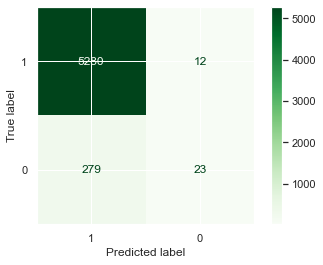

In [44]:
# Lr confusion matrix

plot_confusion_matrix(gs_lr, X_val, y_val, cmap='Greens', 
                      values_format='d', display_labels=['1', '0']);

In [45]:
# test sensitivity of lr

sens_lr = tp_lr / (tp_lr + fn_lr)
sens_lr

0.076158940397351

---
---

### Random forest with GridSearchCV

In [46]:
#Setting a pipeline for Random forest (estimator)
pipe_rf= Pipeline([
                ("rf", RandomForestClassifier())])

In [47]:
#Defining the parameters to gridsearch
param_rf = {
   'rf__n_estimators': [10, 20, 50, 100, 150, 200],
    'rf__max_depth': [5, 10, 15, 20, 25],
    'rf__min_samples_leaf': [2, 5, 10],
    'rf__class_weight' : ['balanced', 'balanced_subsample']
}


In [48]:
# Instantiate GridSearchCV.
gs_rf = GridSearchCV(pipe_rf, param_grid = param_rf, cv = 5, verbose = 1)

In [49]:
#Fitting pipeline to our training set
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('rf', RandomForestClassifier())]),
             param_grid={'rf__class_weight': ['balanced', 'balanced_subsample'],
                         'rf__max_depth': [5, 10, 15, 20, 25],
                         'rf__min_samples_leaf': [2, 5, 10],
                         'rf__n_estimators': [10, 20, 50, 100, 150, 200]},
             verbose=1)

In [50]:
print(f'GridSearch Best Params for Random Forest: {gs_rf.best_params_}')
print('Score on train set:', gs_rf.score(X_train, y_train))
print('Score on test set:', gs_rf.score(X_val, y_val))

GridSearch Best Params for Random Forest: {'rf__class_weight': 'balanced', 'rf__max_depth': 25, 'rf__min_samples_leaf': 2, 'rf__n_estimators': 200}
Score on train set: 0.9953328636843959
Score on test set: 0.9562030747229174


In [51]:
# Get predictions
preds_rf = gs_rf.predict(X_val)

In [52]:
confusion_matrix(y_val, preds_rf)

array([[5227,   65],
       [ 180,  122]])

In [53]:
tn_rf, fp_rf, fn_rf, tp_rf = confusion_matrix(y_val, preds_rf).ravel()
print("True Negatives: %s" % tn_rf)
print("False Positives: %s" % fp_rf)
print("False Negatives: %s" % fn_rf)
print("True Positives: %s" % tp_rf)

True Negatives: 5227
False Positives: 65
False Negatives: 180
True Positives: 122


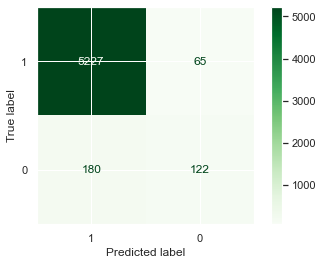

In [54]:
# Random Forest confusion matrix

plot_confusion_matrix(gs_rf, X_val, y_val, cmap='Greens', 
                      values_format='d', display_labels=['1', '0']);

In [55]:
# test sensitivity of rf

sens_rf = tp_rf / (tp_rf + fn_rf)
sens_rf

0.40397350993377484

### Extra Trees with GridSearchCV

In [56]:
#Setting a pipeline for Extra Trees (estimator)
pipe_et= Pipeline([
                ("et", ExtraTreesClassifier())])

In [57]:
#Defining the parameters to gridsearch
param_et = {
    'et__n_estimators': [10, 20, 50, 100, 150, 200],
    'et__max_depth': [2, 3, 4, 5, 10, 20],
    'et__min_samples_leaf': [2, 5, 10],
    'et__class_weight' : ['balanced', 'balanced_subsample']
}


In [58]:
# Instantiate GridSearchCV.
gs_et = GridSearchCV(pipe_et, param_grid = param_et, cv = 5, verbose = 1)

In [59]:
gs_et.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('et', ExtraTreesClassifier())]),
             param_grid={'et__class_weight': ['balanced', 'balanced_subsample'],
                         'et__max_depth': [2, 3, 4, 5, 10, 20],
                         'et__min_samples_leaf': [2, 5, 10],
                         'et__n_estimators': [10, 20, 50, 100, 150, 200]},
             verbose=1)

In [60]:
print(f'GridSearch Best Params for Extra Trees: {gs_et.best_params_}')
print('Score on train set:', gs_et.score(X_train, y_train))
print('Score on test set:', gs_et.score(X_val, y_val))

GridSearch Best Params for Extra Trees: {'et__class_weight': 'balanced', 'et__max_depth': 20, 'et__min_samples_leaf': 2, 'et__n_estimators': 150}
Score on train set: 0.9499823881648468
Score on test set: 0.9054343939935645


In [61]:
# Get predictions
preds_et = gs_et.predict(X_val)

In [62]:
confusion_matrix(y_val, preds_et)

array([[4881,  411],
       [ 118,  184]])

In [63]:
tn_et, fp_et, fn_et, tp_et = confusion_matrix(y_val, preds_et).ravel()
print("True Negatives: %s" % tn_et)
print("False Positives: %s" % fp_et)
print("False Negatives: %s" % fn_et)
print("True Positives: %s" % tp_et)

True Negatives: 4881
False Positives: 411
False Negatives: 118
True Positives: 184


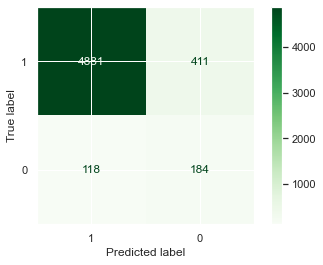

In [64]:
# Extra Trees confusion matrix

plot_confusion_matrix(gs_et, X_val, y_val, cmap='Greens', 
                      values_format='d', display_labels=['1', '0']);

In [65]:
# test sensitivity of et

sens_et = tp_et / (tp_et + fn_et)
sens_et

0.609271523178808

## <span style="color:teal"> 2) Modelling Summary and Selection</span>

**Summary table for Models**

| Model| Train Accuracy|Test Accuracy|   Sensitivity | Baseline acc|True Pos |False Pos|False Neg|True Pos|
|:---------:|:---:|:--------:|:-------:|:----------:|:-----:|:----------:|:-----:|:-------:|
KNearest Neighbours|1.0|0.9476|0.0563|0.0539|5284|8|285|17|
Support Vector Machine|0.9471|0.9458|0.0033|0.0539|5290|8|301|1|
Logistic Regression|0.9488|0.9480|0.0762|0.0539|5280|12|279|23|
Random Forest| 0.9957|0.9544|0.4172|0.0539|5213|79|176|126|
Extra Trees| 0.9521|0.9097|0.6126|0.0539|4904|388|117|185|

In evaluating the models using the various evaluation metrics, we typically rely on the following: 

|Metric| Definition | Scale|
|---|---|---|
|Accuracy|Percentage of observations predicted correctly|0-1|
|Misclassification rate| Percentage of observations predicted wrongly|0-1|
|Specificity|Proportion of actual negatives, which got predicted as the negative |0-1|
|Sensitivity (aka recall)|Proportion of actual positive cases that got predicted as positive |0-1|
|Precision|Ratio between True Positives and all the Positives.|0-1|

For the purpose of our classification problem, we will mainly be focusing on accuracy since our intent is to correctly identify the presence of the West Nile Virus. That said, we are also interested in lowering the chances of false positive (i.e. sensitivity, proportion of actual WNV positive cases that got predicted as positive). 

Taking this two metrics into consideration, we have chosen Random Forest (out of all our models) as it has the highest test accuracy score and a decent sensitivity score. We next plot the ROC curve for our chosen model (i.e. Random Forest).


### ROC Curve

In [66]:
preds_rf = gs_rf.predict_proba(X_val)[:,1]
roc_rf = roc_auc_score(y_val, preds_rf)
print(f'Random Forest ROC_AUC Score:', roc_rf)

Random Forest ROC_AUC Score: 0.9438131028717593


In [67]:
def roc(probas, true, step=0.01):
    """
    probas should be a numpy array of predict_probas
    true is a pandas series of true labels
    step is the step size for checking thresholds
    """
    
    probas = probas[:,1]  # The output of predict_proba() is an array of the probabilities for every class, but we only want the probabilities for class 1
    true = true.values    # We need to convert the class labels from a Pandas Series to a numpy array. We do this using the .values attribute
    assert(len(probas) == len(true)) # We're making sure that our probabilities vector is the same length as our true class labesl vector
    
    TPRs = [] # Setting up empty list of True Positive Rate
    FPRs = [] # Setting up empty list of False Positive Rate
    
    for i in np.arange(0.0,1.0,step): # np.arange allows us to use step sizes that are decimals
        preds_class = probas > i # Numpy arrays have a feature called 'broadcasting.' Check the documentation: https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html to see what this does.
        TP = 0 
        FP = 0
        TN = 0
        FN = 0
        for index in range(len(preds_class)): # We're comparing each prediction with each true value here

            if preds_class[index] == 1 and true[index] == 1:
                TP += 1
            elif preds_class[index] == 1 and true[index] == 0:
                FP += 1
            elif preds_class[index] == 0 and true[index] == 0:
                TN += 1 
            elif preds_class[index] == 0 and true[index] == 1:
                FN += 1
                
        TPR = TP/(TP + FN) # Calculating TPR and FPR and appending to our lists
        FPR = FP/(FP + TN)
        
        TPRs.append(TPR)
        FPRs.append(FPR)
         
    plt.figure(figsize=(10,10))
    plt.rcParams['font.size'] = 14
    plt.plot(FPRs, TPRs, color="orange", label='ROC Curve')
    plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--', label='Baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('Receiver Operating Characteristic')
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.legend()
    plt.show();

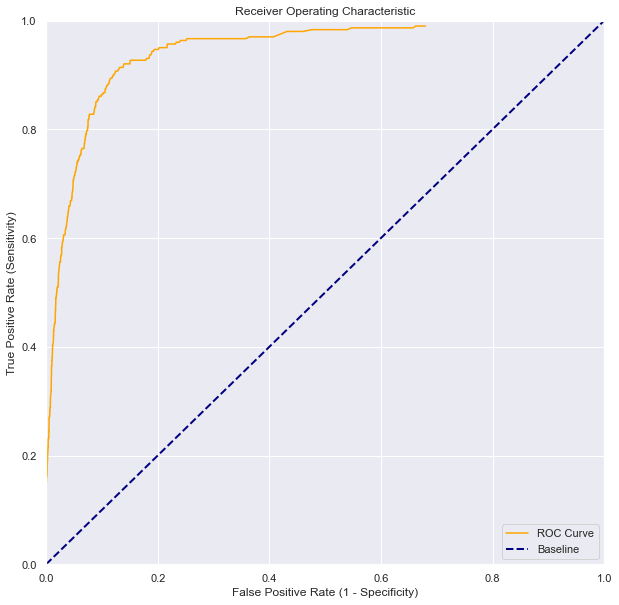

In [68]:
probabilities = gs_rf.predict_proba(X_val)

roc(probas = probabilities, # pass in series of probabilities 
    true = y_val,          # pass in series of true values
    step=0.001);

The ROC curve has a decently smooth curve, with the apex of the curve appearing to between a sensitivity range of 0.8 to 0.9. Hence, this apex would be the best point of probability to detect whether or not the West Nile Virus is present.

In [69]:
# Reinstate X & Y
X = train_weather1
y = train_weather["wnvpresent"]

In [70]:
# split the data into the training and testing sets

X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42
                                                    )

In [71]:
# standard scaler applied

ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_val = ss.transform(X_val)
test_kaggle = ss.transform(test_weather)


In [72]:
#Setting a pipeline for Random forest (estimator)
pipe_rf= Pipeline([
                ("rf", RandomForestClassifier())])

In [73]:
# Using best params
param_rf = {
   'rf__n_estimators': [150],
    'rf__max_depth': [25],
    'rf__min_samples_leaf': [2],
    'rf__class_weight' : ['balanced_subsample']
}


In [74]:
# Instantiate GridSearchCV.
gs_rf = GridSearchCV(pipe_rf, param_grid = param_rf, cv = 5, verbose = 1)

In [75]:
#Fitting pipeline to our training set
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('rf', RandomForestClassifier())]),
             param_grid={'rf__class_weight': ['balanced_subsample'],
                         'rf__max_depth': [25], 'rf__min_samples_leaf': [2],
                         'rf__n_estimators': [150]},
             verbose=1)

In [76]:
print('Score on train set:', gs_rf.score(X_train, y_train))
print('Score on test set:', gs_rf.score(X_val, y_val))

Score on train set: 0.9955089820359282
Score on test set: 0.9567393636038612


In [77]:
# Get predictions
preds_rf = gs_rf.predict(X_val)

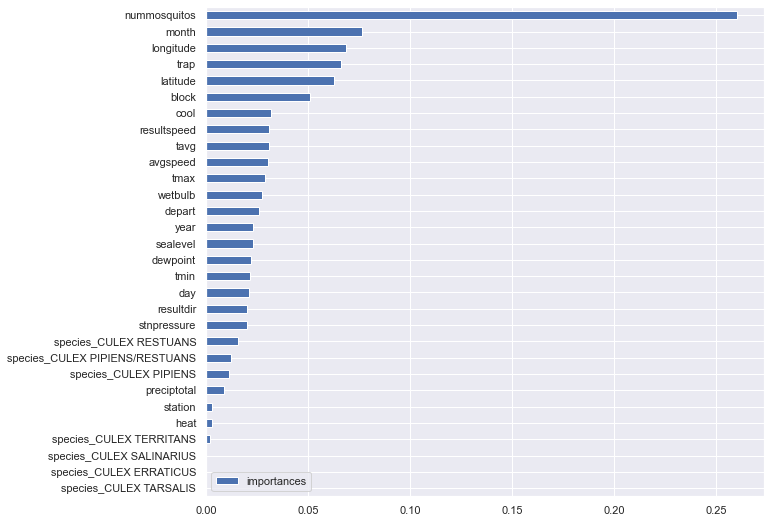

In [78]:
features = pd.DataFrame({
    'features': X.columns,
    'importances': gs_rf.best_estimator_._final_estimator.feature_importances_})
fig = features.sort_values(by='importances', ascending=True).iloc[:30]
fig.plot(kind='barh', figsize=(10,9))
plt.yticks(range(len(fig)),fig['features'])
plt.show()

The table above illustrates the key features that predict the presence of the west Nile Virus (i.e. number of mosquitoes has the highest predictive power while selected species of mosquitoes have the lowest).

---
---

### Kaggle Submission

As Random Forests had the highest accuracy score, that's the model we have used for Kaggle submission

In [79]:
# Get predictions
preds_rf_kaggle = gs_rf.predict(test_weather)

In [80]:
preds_rf_kaggle

array([0, 0, 0, ..., 0, 0, 0])

In [81]:
my_submission1= pd.DataFrame({'Id': test_weather1.id, 'WnvPresent': preds_rf_kaggle})

In [82]:
my_submission1 = my_submission1.drop_duplicates(keep='first')

In [84]:
my_submission1.to_csv('./assets/my_submission1', index=False)

In [85]:
my_submission1

,Id,WnvPresent
0,360,0
2,355,0
4,353,0
6,354,0
8,356,0
...,...,...
232576,116031,0
232578,116033,0
232580,116035,0
232582,116034,0


### Kaggle submission image

<img src="./image/kagglesubmission.jpg" width="1000" height="50">

---
---

## <span style="color:teal"> 3) Cost-Benefit Analysis</span>

### Cost for spraying the whole of Chicago:

Based on external research, we found that: 
- Spraying typically takes place around 8pm until 1am using trucks which dispense an ultra-low-volume spray [*(Source: Chicago city website)*](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_communities/news/2020/aug[…]t/city-to-spray-insecticide-thursday-to-kill-mosquitoes0.html). With the spraying done at odd hours, the chances of human interaction with the insectide are greatly reduced.
-Spray rate is about 1.5 ounces per acre [*(Source: ABC7Chicago)*](https://abc7chicago.com/archive/9206273/)
- Cost per gallon (128 ounces) of Zenivex (i.e. insecticide used) is approximately USD300 [*(Source)*](http://www.gfmosquito.com/wp-content/uploads/2017/07/2017-ND-Mosq.-Control-Quotes-Tabulation.pdf)
- Size on entire chicago is about 149,800 acres in area

Assuming that we want to spray the whole of Chicago,(with an area of 149800 acres) we will need:
#### spray amount = 149800/1.5 => 99866.67
#### spray amount in gallons= 99866.67/128 => 780.21
#### cost of procuring Zenivex = 780.21*300 => $234,062 (for spraying the whole of Chicago once)

If we want to spray the whole of Chicago once every fortnightly for a duration of 6 months (including the summer months), this works out to be: 

#### Annual spray cost =  $2,808,744 (i.e. 234,062 * 12)

---
---

The table below shows the total number of WNV cases reported in USA over the years from 1999 to 2019. These numbers can be significant especially when taking into consideration the nature of the virus. Several cases reported are not severe however, there are a substantial amount that result in neurological symptoms which can have long-term costs. Not forgetting, the significant hospitalisation costs which is seen in the next table. 

**Total Cases in USA Reported from 1999-2019**

| Year | Total Cases Reported (USA)
|:---------:|:---:|
|1999|59|
|2000|19|
|2001|64|
|2002|2946|
|2003|2866|
|3004|1148|
|2005|1309|
|2006|1495|
|2007|1227|
|2008|689|
|2009|386|
|2010|629|
|2011|486|
|2012|2873|
|2013|1267|
|2014|1347|
|2015|1455|
|2016|1309|
|2017|1425|
|2018|1658|
|2019|633|
|Total|25290|

[*source*](https://www.cdc.gov/westnile/statsmaps/cumMapsData.html#one)

**Hospital Costs**


Total estimated costs for United States hospitalized West Nile virus cases and death from 1999 through 2012 by cost category from simulation model in 2012 USD

|Cost category| Mean| 95% CI| Median |Range |Chicago Mean cost |Chicago cost range estimated |
|:---------:|:---:|:---------:|:---:|:---:|:---:|:---:|
|Total acute medical care |252,115,100 |158,022,000–458,998,400| 230,879,300| 115,644,400–2,822,846,000|2,068,705|948,908-23,162,580|
|Total acute lost productivity†| 22,081,260 |9,550,370–63,069,700| 16,144,050 |7,070,480–2,643,251,000|181,185|58,016-21,688,931|
|Total long-term medical care |27,570,280| 11,566,780–56,221,870| 25,468,510| 6,087,800–118,883,900|226,225|49,953-975,489|
|Total long-term lost productivity| 26,866,800 |13,526,800–48,279,320| 25,416,720| 7,790,800–85,567,700|220,452|63,927-702,117|
|Total lifetime lost productivity caused by deaths‡ |449,464,800| (NA)| 449,464,800 | (NA)|3,688,038|NA|

*All values are in USD

*Multiplied the mean and range of USA costs by 0.008205 which is Chicago's population ratio over USA

*Represents the mean and median of the 10,000 outputs from the Monte Carlo simulation model for 18,256 hospitalized West Nile virus (WNV) disease cases

†Includes only survivors

‡Lifetime lost productivity was calculated directly from Grosse and others based on age and sex for the 1,524 WNV disease case-patients reported to Centers for Disease Control (Staples et al, 2014) [*(Source)*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3945683/pdf/tropmed-90-402.pdf) 

The total estimated hospitalisation costs are high and this do not include outpatient visits and discharged patients follow up costs. 

Nonetheless, the important takeaway from our external research is that the benefits of fogging the entire City of Chicago greatly outweights the cost. Specifically, there are 
huge savings re hospitalisation bills that we can reap if we manage to eradicate the West Nile Virus via fogging of entire Chicago city once every fortnightly for 6 months. 

---
---

## <span style="color:teal"> 5) Executive Summary</span>

**Recap of problem statement**
    
We are a group of data scientists working who just started work at the Disease And Treatment Agency, division of Societal Cures In Epidemiology and New Creative Engineering (DATA-SCIENCE). Due to the recent epidemic of West Nile Virus in the Windy City, we've been tasked by the Department of Public Health to build a classifer model to predict the possibility of west Nile Virus occuring on various locations of interest based on the data collected over time. It is our hope that with the model, we could make more informed decisions on the deployment of pesticides in the fight for public health and safety. While pesticides are a necessary evil in the fight against the West Nile Virus, it is very expensive. At such, we will also conduct a cost-benefit analysis regarding use of pesticides to manage the epidemic.

**Summary**
Having evaluate five models for our classifier (i.e. KNN, SMV, Log Reg, Random Forest and Extra Trees), their respective scores are as such:

| Model| Train Accuracy|Test Accuracy|   Sensitivity | Baseline acc|True Pos |False Pos|False Neg|True Pos|
|:---------:|:---:|:--------:|:-------:|:----------:|:-----:|:----------:|:-----:|:-------:|
KNearest Neighbours|1.0|0.9476|0.0563|0.0539|5284|8|285|17|
Support Vector Machine|0.9471|0.9458|0.0033|0.0539|5290|8|301|1|
Logistic Regression|0.9488|0.9480|0.0762|0.0539|5280|12|279|23|
Random Forest| 0.9957|0.9544|0.4172|0.0539|5213|79|176|126|
Extra Trees| 0.9521|0.9097|0.6126|0.0539|4904|388|117|185|

As we are concerned about correctly identifying the presence of the West Nile Virus, we have predominantly used the test accuracy score to choose the best performing model. Notwithstanding this, we also looked at the sensitivity score so as to ensure that we keep our false positives to a minimum. Taking these two evaluation metrics into account, we observed that our Random Forest model is the most ideal (i.e. test accuracy of 0.9544 and sensitivity of 0.4172). 

This goes to suggest that our model predicts 95.44% of the test observations correctly. Among obsevations that have the West Nile Virus, our model has 41.72% of them classified accurately.

Re cost-benefit analysis, our earlier paragraph shows that the cost of spraying the whole of Chicago fortnightly for 6 months (including the summer months) will cost about $2.8mil. This is far lower that the total estimated hospitalisation costs (see figures under "Chicago Mean Cost" from table above) from West Nile Virus and demonstrates a clear impetus for the city of Chicago to spray insecticide city-wide to reduce the spread of the virus. 


---
---